
## NYC MTA Turnstile
Dataset: http://web.mta.info/developers/turnstile.html

## Table of Contents:
* [Note: Limiting Data](#first-bullet)
* [Download Files](#second-bullet)
* [Pre2014 Data Prep](#third-bullet)
** [Create a Pre2014 Dataset](#a-bullet)
** [Aggregate Pre2014 Dataset to Daily Grain](#b-bullet)
** [Clean Pre2014 Dataset](#c-bullet)
* [Post2014 Data Prep](#fourth-bullet)
** [Create a Post2014 Dataset](#d-bullet)
** [Aggregate Post2014 Dataset to Daily Grain](#e-bullet)
** [Clean Post2014 Dataset](#f-bullet)
* [Enrich Pre2014 Dataset](#fifth-bullet)
* [Create Daily Turnstile Dataset](#sixth-bullet)
* [Data Analysis](#seventh-bullet)
* [Data Visualization](#eighth-bullet)
* [Bonus Question](#ninth-bullet)

In [4]:
from bs4 import BeautifulSoup as bs
import requests
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/Users/sallyduong/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## [NOTE] Limiting Data <a class="anchor" id="first-bullet"></a>
Due to limitation of the processing power of my personal computer, I am limiting the amount of data I am working with. The variables below are used to set the date range.
Assumption: The data quality from 01/01/2013 to 12/31/2014 is representative of the entire dataset.

In [3]:
# Set start and end date range for limiting data
limitStartDate = 130101  # Jan 1, 2013
limitEndDate = 141231  # Dec 31, 2014

# If your computer is more powerful than mine (which I hope it is!), comment out the above and uncomment
# the below.
# limitStartDate = 100505 # May 5, 2010
# limitEndDate = 230121 # Jan 21, 2023, or update to most recent date

<IPython.core.display.Javascript object>

# Download Files to Local Machine & Create List of Target Files to Open <a class="anchor" id="second-bullet"></a>

Using Beautiful Soup, parse through the NYC MTA Turnstile website and download relevant files.
To get more details about the website, use the 'Inspect Element' functionality within your browser.

<b>Data will be split into two groups... pre2014 = prior to 10/18/2014, and post2014 = current</b>

In [5]:
domain = "http://web.mta.info/developers/"
url = "http://web.mta.info/developers/turnstile.html"

# Specify what data from the website we're looking for and the expected filetype
keywordTurnstile = "data/nyct/turnstile/turnstile"
filetype = ".txt"

# Specify when the schema changed (September 18, 2014)
# Data will be split into two groups... pre2014 = prior to 10/18/2014, and post2014 = current
schemaChange_2014 = 141018

In [6]:
def get_soup(url):
    return bs(requests.get(url).text, "html.parser")


# Variables to store list of file names that we want to open
fileNames_pre2014 = []
fileNames_post2014 = []

# Go through every href link on the page. If it meets our criteria, download the file and add the name of the
# file to our list.
for link in get_soup(url).find_all("a", href=True):
    file_link = link.get("href")

    # pre2014
    if (
        (keywordTurnstile in file_link)
        and (filetype in file_link)
        and (int((file_link[-10:-4])) >= limitStartDate)
        and (int((file_link[-10:-4])) < schemaChange_2014)
    ):
        # Comment entire with block below to not download file
         with open(link.text, 'wb') as file:
                response = requests.get(domain + file_link)
                file.close()
                
                fileNames_pre2014.append(link.text)

    # post2014
    elif (
        (keywordTurnstile in file_link)
        and (filetype in file_link)
        and (int((file_link[-10:-4])) <= limitEndDate)
        and (int((file_link[-10:-4])) >= schemaChange_2014)
    ):
        # Comment entire with block below to not download file
         with open(link.text, 'wb') as file:
                response = requests.get(domain + file_link)
                file.write(response.content)
                file.close()
                
                fileNames_post2014.append(link.text)

# Pre2014 Data Prep <a class="anchor" id="third-bullet"></a>


### Table of Contents:
* [Create a Pre2014 Dataset](#a-bullet)
* [Aggregate Pre2014 Dataset to Daily Grain](#b-bullet)
* [Clean Pre2014Dataset](#C-bullet)

## Create a Pre2014 Dataset <a class="anchor" id="a-bullet"></a>
Take all pre2014 files (prior to September 18, 2014) and union them into one dataset.

In [7]:
dataset_pre2014 = []

# Through the process of concatnating pre-2014 data, the below datasets were identified as malformed
# Assumption: malformed datasets are inaccurate datasets and can be ignored
malformed_datasets = ["Saturday, July 14, 2012", "Saturday, May 05, 2012"]

# Union all pre2014 data into one dataset and do not include the malformed datasets
for file in fileNames_pre2014:

    file_datapoints = []
    
    if file not in malformed_datasets:
        with open(file) as f:
            for line in f:
                line = line.strip().split(",")
                prefix = line[:3]
                
                for i in range(3, len(line), 5):
                    suffix = line[i:i+5]
                    file_datapoints.append(prefix + suffix)
                
        dataset_pre2014.append(pd.DataFrame(data = file_datapoints))
    
dataset_pre2014 = pd.concat(dataset_pre2014)


ValueError: No objects to concatenate

In [7]:
# Rename columns from Range Index to expected field names
dataset_pre2014.columns = [
    "C/A",
    "UNIT",
    "SCP",
    "DATE",
    "TIME",
    "DESC",
    "ENTRIES",
    "EXITS",
]

<IPython.core.display.Javascript object>

## Aggregate Pre2014 Dataset to Daily Grain <a class="anchor" id="b-bullet"></a>

Since the lowest grain of the data needed for analysis and visualization is at the daily grain, pre-aggregate the dataset. This passes less data downstream and allows for faster runtime.
</br>
</br>
As mentioned in the instructions document, the turnstile devices function like an odometer. So, we can utilize the max() function to get the last recorded count of entries and exits.

In [8]:
# Set Entries and Exits to datatype Float so that they can be aggregated
dataset_pre2014 = dataset_pre2014.astype({"ENTRIES": "float", "EXITS": "float"})
# print(dataset_pre2014.dtypes)

<IPython.core.display.Javascript object>

In [9]:
# Aggregate by day, and take the total entries and exits per day
dataset_pre2014_daily = dataset_pre2014.groupby(
    ["C/A", "UNIT", "SCP", "DATE", "DESC"], as_index=False
).agg(dailyEntries=("ENTRIES", "max"), dailyExits=("EXITS", "max"))

<IPython.core.display.Javascript object>

## Clean Pre2014 Dataset <a class="anchor" id="c-bullet"></a>

Perform a series of tests to uncover potential data quality concerns. </br>
From the analysis, only DESC had a data quality concern (unexpected values).
</br>
</br>
Assumption: the subset of pre2014 data is representative of the entire dataset.


In [10]:
# Check DESC for expected values
dataset_pre2014_i4 = dataset_pre2014_daily.groupby(["DESC"]).count()
print(dataset_pre2014_i4)

# Keep rows where DESC is Regular or Recover Aud
# Assumption: Since the MTA website did not mention other values for DESC beyond Regular or Recover Aud,
# assume that they are inaccurate records
dataset_pre2014_daily = dataset_pre2014_daily.loc[
    (dataset_pre2014_daily["DESC"] == "REGULAR")
    | (dataset_pre2014_daily["DESC"] == "RECOVR AUD")
]

                C/A     UNIT      SCP     DATE  dailyEntries  dailyExits
DESC                                                                    
064               1        1        1        1             1           1
069               1        1        1        1             1           1
9798999A9B        1        1        1        1             1           1
DOOR CLOSE   182451   182451   182451   182451        182451      182451
DOOR OPEN    235448   235448   235448   235448        235448      235448
LGF-MAN      125983   125983   125983   125983        125983      125983
LGF-SHUTDN        2        2        2        2             2           2
LOGON        162665   162665   162665   162665        162665      162665
RECOVR AUD   745482   745482   745482   745482        745482      745482
REGULAR     2910322  2910322  2910322  2910322       2910322     2910322
TS BRD CHG        2        2        2        2             2           2
TS VLT OPN        8        8        8        8     

<IPython.core.display.Javascript object>

# Post2014 Data Prep <a class="anchor" id="fourth-bullet"></a>


### Table of Contents:
* [Create a Post2014 Dataset](#d-bullet)
* [Aggregate Post2014 Dataset to Daily Grain](#e-bullet)
* [Clean Post2014Dataset](#f-bullet)

##  Create a Post2014 Dataset <a class="anchor" id="d-bullet"></a>
Take all post2014 files (on and after September 18, 2014) and union them into one dataset.

In [11]:
# Since post 2014 data does not contain malformed data set, union as is

# Variable for all post2014 data
dataset_post2014 = []

# Union all post2014 data into one dataset
for file in fileNames_post2014:
    dataset_post2014.append(pd.read_csv(file))

dataset_post2014 = pd.concat(dataset_post2014)

<IPython.core.display.Javascript object>

## Aggregate Post2014 Dataset to Daily Grain <a class="anchor" id="e-bullet"></a>
Since the lowest grain of the data needed for analysis and visualization is at the daily grain, pre-aggregate the dataset. This passes less data downstream and allows for faster runtime.
</br>
</br>
As mentioned in the instructions document, the turnstile devices function like an odometer. So, we can utilize the max() function to get the last recorded count of entries and exits.

In [43]:
# Remove trailing white spaces in Exits column name
dataset_post2014 = dataset_post2014.rename(
    columns={
        "EXITS                                                               ": "EXITS"
    }
)

# Aggregate by day, and take the total entries and exits per day
# Since the turnstiles function like an odometer, the maximum can be used as the final tally of the day
dataset_post2014_daily = dataset_post2014.groupby(
    ["C/A", "UNIT", "SCP", "STATION", "LINENAME", "DIVISION", "DATE", "DESC"],
    as_index=False,
).agg(dailyEntries=("ENTRIES", "max"), dailyExits=("EXITS", "max"))

<IPython.core.display.Javascript object>

## Clean Post 2014 Dataset <a class="anchor" id="f-bullet"></a>

Assumption: Checks used in the Pre2014 dataset are the same for Post2014.

In [44]:
# Check DIVISION by expected length
dataset_post2014_i5 = dataset_post2014_daily.groupby(
    ["DIVISION"], as_index=False
).count()
# print(dataset_post2014_i5)

# The MTA website's Field Description page only lists BMT, IRT, and IND as stations
# Assumption: fields with other division names are incorrect and can be removed
dataset_post2014_daily = dataset_post2014_daily.loc[
    (dataset_post2014_daily["DIVISION"] == "BMT")
    | (dataset_post2014_daily["DIVISION"] == "IRT")
    | (dataset_post2014_daily["DIVISION"] == "IND")
]

#print(dataset_post2014_daily)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,DESC,dailyEntries,dailyExits
0,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/11/2014,REGULAR,4821671.0,1635968.0
1,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/12/2014,REGULAR,4822536.0,1636200.0
2,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/13/2014,REGULAR,4824028.0,1636676.0
3,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/14/2014,REGULAR,4825723.0,1637243.0
4,A002,R051,02-00-00,LEXINGTON AVE,NQR456,BMT,10/15/2014,REGULAR,4827475.0,1637859.0
...,...,...,...,...,...,...,...,...,...,...
310407,R730,R431,00-00-04,DYRE AVE,5,IRT,12/23/2014,RECOVR AUD,2212838.0,911175.0
310408,R730,R431,00-00-04,DYRE AVE,5,IRT,12/23/2014,REGULAR,2213013.0,911322.0
310409,R730,R431,00-00-04,DYRE AVE,5,IRT,12/24/2014,REGULAR,2213344.0,911469.0
310410,R730,R431,00-00-04,DYRE AVE,5,IRT,12/25/2014,REGULAR,2213414.0,911499.0


<IPython.core.display.Javascript object>

In [46]:
# Keep rows where DESC is Regular or Recover Aud
# Assumption: Since the MTA website did not mention other values for DESC beyond Regular or Recover Aud,
# assume that they are inaccurate records
dataset_post2014_daily = dataset_post2014_daily.loc[
    (dataset_post2014_daily["DESC"] == "REGULAR")
    | (dataset_post2014_daily["DESC"] == "RECOVR AUD")
]

<IPython.core.display.Javascript object>

# Enrich Pre2014 Data  <a class="anchor" id="fifth-bullet"></a>
Problem: pre2014 dataset does not include fields STATION, LINENAME, and DIVISION 
Hypothesis: The 3 fields can be inferred from a combination of C/A, UNIT, and SCP
</br> </br>
Join all possible combinations of STATION, LINENAME, and DIVISION (uniqueCombos = uC2) to the daily aggregated pre-2014 dataset (dataset_pre2014_daily). 

In [47]:
# Get all unique combinations of C/A, UNIT, SCP, STATION, LINENAME, and DIVISION  from post2014 dataset
# since STATION, LINENAME, and DIVISION are only available in post2014
uC2 = dataset_post2014_daily.groupby(
    ["C/A", "UNIT", "SCP", "DESC", "STATION", "DIVISION", "LINENAME"], as_index=False
).count()

# Only keep relevant columns for joining to pre2014 data
uC2 = uC2.drop(columns=["DATE", "dailyEntries", "dailyExits"])

# print(dataset_pre2014_daily.columns)
# print(dataset_post2014_daily.columns)
# print(uC2.columns)

<IPython.core.display.Javascript object>

In [48]:
# Join dataframes to enrich pre2014 data with STATION, LINENAME, and DIVISION
enriched_pre2014_daily = pd.merge(
    dataset_pre2014_daily,
    uC2,
    on=["C/A", "UNIT", "SCP", "DESC"],
    how="left",
    suffixes=["_l", "_r"],
)

<IPython.core.display.Javascript object>

In [49]:
# (Optional) Validating expected number of rows
print(
    "Is the count of rows from the pre2014 daily dataset and from the enriched pre2014 daily dataset the same? "
    + str(len(dataset_pre2014_daily.index) == len(enriched_pre2014_daily.index))
)

Is the count of rows from the pre2014 daily dataset and from the enriched pre2014 daily dataset the same? True


<IPython.core.display.Javascript object>

# Create Daily Turnstile Dataset <a class="anchor" id="sixth-bullet"></a>
Union the enriched pre2014 and post2014 dataset to create a single dataset that contains turnstile activity at the daily grain.

In [50]:
turnstileDaily = pd.concat([enriched_pre2014_daily, dataset_post2014_daily])
# print(turnstileDaily.head(50))

# (Optional) Validating expected number of rows
print(
    "Is the count of rows from the enriched pre2014 daily dataset plus post2014 daily dataset equal to "
)
print(
    "the new unioned dataframe? "
    + str(
        (len(dataset_post2014_daily.index) + len(enriched_pre2014_daily.index))
        == len(turnstileDaily.index)
    )
)

Is the count of rows from the enriched pre2014 daily dataset plus post2014 daily dataset equal to 
the new unioned dataframe? True


<IPython.core.display.Javascript object>

In [18]:
# Clean and update datatypes

# Replace nulls with 0
turnstileDaily = turnstileDaily.fillna(0)

# Update Date datatypes
turnstileDaily["DATE"] = pd.to_datetime(turnstileDaily["DATE"])

# Update string and int datatypes
turnstileDaily = turnstileDaily.astype(
    {
        "C/A": "string",
        "UNIT": "string",
        "SCP": "string",
        "DESC": "string",
        "dailyEntries": "int",
        "dailyExits": "int",
        "STATION": "string",
        "DIVISION": "string",
        "LINENAME": "string",
    }
)
# print(turnstileDaily.dtypes)

<IPython.core.display.Javascript object>

# Data Analysis <a class="anchor" id="seventh-bullet"></a>

### Table of Contents:
* [Which station has the most number of units?](#g-bullet)
* [What is the total number of entries & exits across the subway system for February 1, 2013?](#h-bullet)
* [What station was the busiest on February 1, 2013?](#i-bullet)
* [What turnstile was the busiest on February 1, 2013?](#j-bullet)
* [What stations have seen the most usage growth/decline in 2013?](#k-bullet)
* [What dates are the least busy?](#l-bullet)

#### Which station has the most number of units? <a class="anchor" id="g-bullet"></a>

In [35]:
# Which station has the most number of units?

# Calculate how many units (count distinct) are in each station
unitsPerStation = turnstileDaily.groupby(['STATION']).agg(countOfUnits=('UNIT', 'nunique'))

# Find station with the most units
mostUnitsInAStation = (unitsPerStation[unitsPerStation['countOfUnits'] == unitsPerStation['countOfUnits'].max()])
print(mostUnitsInAStation)


         countOfUnits
STATION              
0                 315


<IPython.core.display.Javascript object>

#### What is the total number of entries & exits across the subway system for February 1, 2013? <a class="anchor" id="h-bullet"></a>

In [20]:
# What is the total number of entries & exits across the subway system for Feb 1, 2013?

feb1 = "02-01-2013"

# Filter for only Feb 1, 2023 data
feb1Dataset = turnstileDaily.loc[(turnstileDaily["DATE"] == feb1)]


# Calculate total number of entries and exits on that day
feb1EntriesExits = feb1Dataset.groupby(["DATE"]).agg(
    totalEntries=("dailyEntries", "sum"), totalExits=("dailyExits", "sum")
)
print(feb1EntriesExits)

            totalEntries   totalExits
DATE                                 
2013-02-01   20388626552  11425974944


<IPython.core.display.Javascript object>

#### What station was the busiest on February 1, 2013? <a class="anchor" id="i-bullet"></a>

In [21]:
# What station was the busiest on Feb 1, 2013?
# Busyness = sum of entry and exit count

# Calculate for total number of entries and exits per station on Feb 1, 2023
feb1EntriesExitsByStation = feb1Dataset.groupby(['STATION'],as_index=False).agg(totalEntries=('dailyEntries', 'sum'),
                                                                 totalExits=('dailyExits', 'sum'))
# Sum total entries and exits per station on Feb 1, 2023
feb1EntriesExitsByStation['busyness'] = feb1EntriesExitsByStation['totalEntries'] + feb1EntriesExitsByStation['totalExits']

# Find the most busiest station
busiestStation = (feb1EntriesExitsByStation[feb1EntriesExitsByStation['busyness'] == feb1EntriesExitsByStation['busyness'].max()])

print(busiestStation)


          STATION  totalEntries  totalExits    busyness
97  66 ST-LINCOLN     669910398   672883026  1342793424


<IPython.core.display.Javascript object>

#### What turnstile was the busiest on February 1, 2013? <a class="anchor" id="j-bullet"></a>

In [22]:
# What turnstile was the busiest on that date?
# Assumption: turnstile = UNIT

# Calculate for total number of entries and exits per UNIT on Feb 1, 2013
feb1EntriesExitsByUnit = feb1Dataset.groupby(["UNIT"], as_index=False).agg(
    totalEntries=("dailyEntries", "sum"), totalExits=("dailyExits", "sum")
)
# Sum total entries and exits per station on Feb 1, 2013
feb1EntriesExitsByUnit["busyness"] = (
    feb1EntriesExitsByUnit["totalEntries"] + feb1EntriesExitsByUnit["totalExits"]
)

# Find the busiest station
busiestUnit = feb1EntriesExitsByUnit[
    feb1EntriesExitsByUnit["busyness"] == feb1EntriesExitsByUnit["busyness"].max()
]

print(busiestUnit)

     UNIT  totalEntries  totalExits    busyness
153  R164     682948098   686985026  1369933124


<IPython.core.display.Javascript object>

#### What stations have seen the most usage growth/decline in 2013? <a class="anchor" id="k-bullet"></a>
There are many ways to interpret growth and decline. I will measure growth/decline as the difference between the busyness between the month of Jan vs the month of Dec 2013.

In [36]:
# What stations have seen the most usage growth/decline in 2013?
# There are many ways to interpret the above. I will measure growth/decline as the difference between the
# busyness between the month of Jan vs the month of Dec 2013.

# Copy dataset as to not accidentally change it
growthDeclineDataset = turnstileDaily

# Filter for only 2013 data
growthDeclineDataset = growthDeclineDataset[
    (growthDeclineDataset["DATE"].dt.year == 2013)
]

# Create a Jan and Dec only dataset
janMonthNum = 1
decMonthNum = 12

jan_growthDeclineDataset = growthDeclineDataset[
    (growthDeclineDataset["DATE"].dt.month == janMonthNum)
]
dec_growthDeclineDataset = growthDeclineDataset[
    (growthDeclineDataset["DATE"].dt.month == decMonthNum)
]

# Calculate busyness as total number of entries and exits per station in jan and dec
jan_entriesExitsByStation = jan_growthDeclineDataset.groupby(
    ["STATION"], as_index=False
).agg(totalEntries=("dailyEntries", "sum"), totalExits=("dailyExits", "sum"))

jan_entriesExitsByStation["busyness"] = (
    jan_entriesExitsByStation["totalEntries"] + jan_entriesExitsByStation["totalExits"]
)

dec_entriesExitsByStation = dec_growthDeclineDataset.groupby(
    ["STATION"], as_index=False
).agg(totalEntries=("dailyEntries", "sum"), totalExits=("dailyExits", "sum"))

dec_entriesExitsByStation["busyness"] = (
    dec_entriesExitsByStation["totalEntries"] + dec_entriesExitsByStation["totalExits"]
)


# Compare busyness per station of Jan vs. Dec

# Join the two datasets
janDec_Dataset = pd.merge(
    jan_entriesExitsByStation,
    dec_entriesExitsByStation,
    on=["STATION"],
    how="inner",
    suffixes=["_jan", "_dec"],
)

# Calculate growth/decline by finding the difference in busyness
janDec_Dataset["growthDecline"] = (
    janDec_Dataset["busyness_dec"] - janDec_Dataset["busyness_jan"]
)

# Drop unused columns for clarity
janDec_Dataset = janDec_Dataset.drop(
    columns=[
        "totalEntries_jan",
        "totalExits_jan",
        "busyness_jan",
        "totalEntries_dec",
        "totalExits_dec",
        "busyness_dec",
    ]
)


# Station with the most DECLINE (negative busyness difference from Jan to Dec)
stationDecline = janDec_Dataset[
    janDec_Dataset["growthDecline"] == janDec_Dataset["growthDecline"].min()
]
print("The Station with the most DECLINE in 2013:")
print(stationDecline)

# Station with the most GROWTH (positive busyness difference from Jan to Dec)
stationGrowth = janDec_Dataset[
    janDec_Dataset["growthDecline"] == janDec_Dataset["growthDecline"].max()
]
print("The Station with the most GROWTH in 2013:")
print(stationGrowth)

The Station with the most DECLINE in 2013:
       STATION  growthDecline
226  FULTON ST   -36494722288
The Station with the most GROWTH in 2013:
      STATION  growthDecline
199  DYRE AVE    64164512028


<IPython.core.display.Javascript object>

#### What dates are the least busy? Could you identify days on which stations were not operating at full capacity or closed entirely? <a class="anchor" id="l-bullet"></a>
</br>
Assumption: Scope is still 2013.

In [24]:
# What dates are the least busy?

# Filter for only 2013 data
dataset2013 = turnstileDaily[(turnstileDaily["DATE"].dt.year == 2013)]

## Remove days where stations were not operating at full capacity or were closed entirely.

# Assumption: 0 dailyEntries or 0 dailyExits indicates the station that day was closed entirely
dataset2013 = dataset2013.loc[
    (dataset2013["dailyEntries"] != 0) | (dataset2013["dailyExits"] != 0)
]

# Assumption: median dailyEntries and median dailyExits indicates 'full capacity'
medianStationCapacity = dataset2013.groupby(["STATION"], as_index=False).agg(
    medianEntries=("dailyEntries", "median"), medianExits=("dailyExits", "median")
)

# Join 2013 dataset with findings from median station capacity dataset
# Only keep records where the daily entries was greater than or equal to median entries for that station
# or where the daily exits was greater than or equal to median exits for that station
enriched2013 = pd.merge(
    dataset2013,
    medianStationCapacity,
    on=["STATION"],
    how="inner",
    suffixes=["_l", "_r"],
)

enriched2013["keepFlag"] = np.where(
    (enriched2013["dailyEntries"] >= enriched2013["medianEntries"])
    | (enriched2013["dailyExits"] >= enriched2013["medianExits"]),
    True,
    False,
)

enriched2013 = enriched2013.loc[(enriched2013["keepFlag"] == True)]


# Calculate busyness per day by summing total entries and exits per day
dailybusyness = dataset2013.groupby(["DATE"], as_index=False).agg(
    totalEntries=("dailyEntries", "sum"), totalExits=("dailyExits", "sum")
)


dailybusyness["busyness"] = dailybusyness["totalEntries"] + dailybusyness["totalExits"]

dailybusyness = dailybusyness.sort_values(by="busyness", ascending=False)

# The least busy day
leastBusyDay = dailybusyness[
    dailybusyness["busyness"] == dailybusyness["busyness"].min()
]

print(leastBusyDay)

         DATE  totalEntries  totalExits     busyness
74 2013-03-16   17765147879  9951231837  27716379716


<IPython.core.display.Javascript object>

# Visualization  <a class="anchor" id="eighth-bullet"></a>

### Table of Contents:
* [Plot the daily row counts for data files in Q1 2013.](#m-bullet)
* [Plot the daily total number of entries & exits across the system for Q1 2013.](#n-bullet)
* [Plot the mean and standard deviation of the daily total number of entries &amp; exits for each month in Q1 2013 for station 34 ST-PENN STA.](#o-bullet)

In [25]:
# Filter dataset for only Q1 2013
datasetQ12013 = turnstileDaily[(turnstileDaily["DATE"].dt.year == 2013)]
datasetQ12013 = datasetQ12013[(datasetQ12013["DATE"].dt.quarter.isin([1]))]

<IPython.core.display.Javascript object>

#### Plot the daily row counts for data files in Q1 2013 <a class="anchor" id="m-bullet"></a>

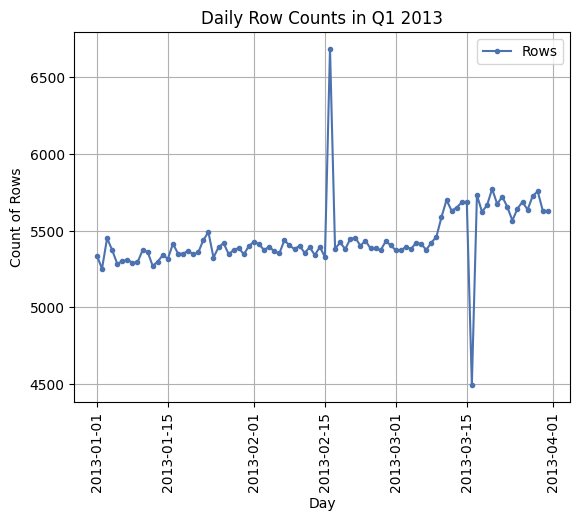

<IPython.core.display.Javascript object>

In [26]:
# Calculate the count how many rows there are per day
dailyRowCountDataset = datasetQ12013.groupby(["DATE"], as_index=False).agg(
    dailyRowCount=("DATE", "count")
)

# Plot as a line graph with date on the x-axis
plt.style.use("seaborn-v0_8-deep")

plt.plot(
    dailyRowCountDataset["DATE"],
    dailyRowCountDataset["dailyRowCount"],
    marker=".",
    label="Rows",
)

plt.title("Daily Row Counts in Q1 2013")
plt.xlabel("Day")
plt.ylabel("Count of Rows")


plt.xticks(rotation=90)

plt.legend(loc="best")
plt.grid(True)

#### Plot the daily total number of entries & exits across the system for Q1 2013. <a class="anchor" id="n-bullet"></a>

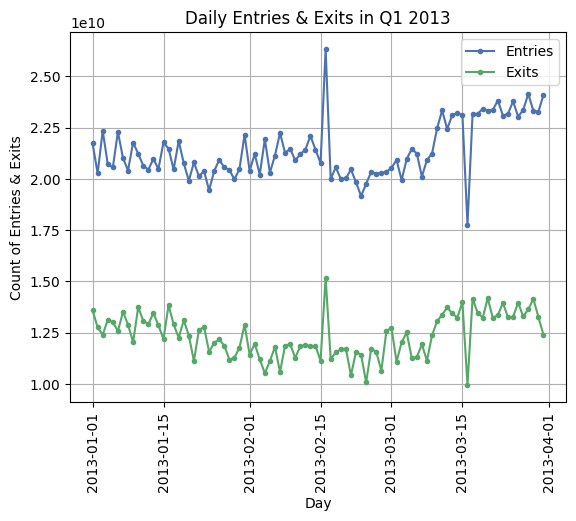

<IPython.core.display.Javascript object>

In [27]:
# Calculate entries & exits per day
dailyEntriesExitsDataset = datasetQ12013.groupby(["DATE"], as_index=False).agg(
    totalEntries=("dailyEntries", "sum"), totalExits=("dailyExits", "sum")
)

# Plot as a double line chart
plt.style.use("seaborn-v0_8-deep")

plt.plot(
    dailyEntriesExitsDataset["DATE"],
    dailyEntriesExitsDataset["totalEntries"],
    marker=".",
    label="Entries",
)
plt.plot(
    dailyEntriesExitsDataset["DATE"],
    dailyEntriesExitsDataset["totalExits"],
    marker=".",
    label="Exits",
)

plt.title("Daily Entries & Exits in Q1 2013")
plt.xlabel("Day")
plt.ylabel("Count of Entries & Exits")

plt.xticks(rotation=90)

plt.legend(loc="best")
plt.grid(True)
# plt.tight_layout()
# plt.show

#### Plot the mean and standard deviation of the daily total number of entries &amp; exits for each month in Q1 2013 for station 34 ST-PENN STA <a class="anchor" id="o-bullet"></a>

In [28]:
# Filter for only records where the station is Penn Station
dailyEE_Penn = datasetQ12013[datasetQ12013["STATION"] == "34 ST-PENN STA"]

# Calculate daily entries and exits
dailyEE_Penn = dailyEE_Penn.groupby(["DATE"], as_index=False).agg(
    totalEntries=("dailyEntries", "sum"), totalExits=("dailyExits", "sum")
)

# Add new field Month
dailyEE_Penn["MonthNum"] = dailyEE_Penn["DATE"].dt.month
dailyEE_Penn["Month"] = dailyEE_Penn["DATE"].dt.month_name()
# print(dailyEE_Penn)

# Calculate mean and standard deviation per month for total entries and total exits
dailyEE_Penn = dailyEE_Penn.groupby(["MonthNum", "Month"], as_index=False).agg(
    meanEntries=("totalEntries", "mean"),
    meanExits=("totalExits", "mean"),
    stdEntries=("totalEntries", "std"),
    stdExits=("totalExits", "std"),
)
# Change datatypes from float to int
dailyEE_Penn = dailyEE_Penn.astype(
    {
        "MonthNum": "int",
        "Month": "string",
        "meanEntries": "int",
        "meanExits": "int",
        "stdEntries": "int",
        "stdExits": "int",
    }
)

# print(dailyEE_Penn.dtypes)

<IPython.core.display.Javascript object>

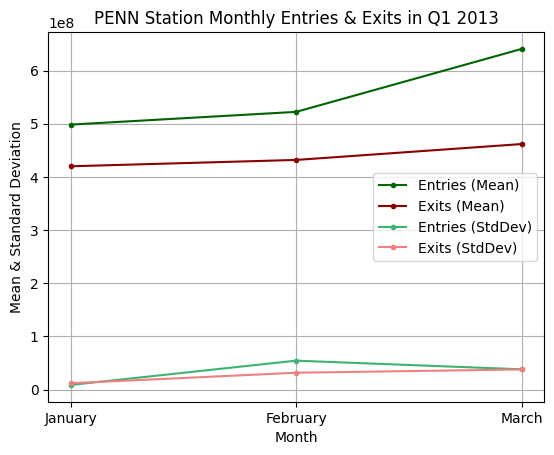

<IPython.core.display.Javascript object>

In [29]:
# Plot as a line chart
plt.style.use("seaborn-v0_8-deep")

# Mean Entries
plt.plot(
    dailyEE_Penn["Month"],
    dailyEE_Penn["meanEntries"],
    marker=".",
    color="darkgreen",
    label="Entries (Mean)",
)
# Mean Exits
plt.plot(
    dailyEE_Penn["Month"],
    dailyEE_Penn["meanExits"],
    marker=".",
    color="darkred",
    label="Exits (Mean)",
)
# Standard Deviation Entries
plt.plot(
    dailyEE_Penn["Month"],
    dailyEE_Penn["stdEntries"],
    marker=".",
    color="mediumseagreen",
    label="Entries (StdDev)",
)
# Standard Deviation Exits
plt.plot(
    dailyEE_Penn["Month"],
    dailyEE_Penn["stdExits"],
    marker=".",
    color="lightcoral",
    label="Exits (StdDev)",
)


plt.title("PENN Station Monthly Entries & Exits in Q1 2013")
plt.xlabel("Month")
plt.ylabel("Mean & Standard Deviation")

# plt.xticks(rotation=90)

plt.legend(loc="best")
plt.grid(True)
# plt.tight_layout()
# plt.show

# Bonus Question <a class="anchor" id="ninth-bullet"></a>
## What hour is the busiest for station CANAL ST in Q1 2013?
</br>
Since the turnstile functions as like an odometer, the records later in the day are liekly to skew the results. For this analysis, define "busyness" as the <i> difference </i> of Entries and Exits. 

In [30]:
# Bonus: What hour is the busiest for station CANAL ST in Q1 2013?

# Duplicate data as to not unintentionally change existing one
bonusQ_dataset = dataset_pre2014

# Change datatype Date and Time to datetime
bonusQ_dataset = bonusQ_dataset.astype({"DATE": "datetime64", "TIME": "datetime64"})

<IPython.core.display.Javascript object>

In [32]:
# Enrich dataset with STATION
enriched_canalSt_dataset = pd.merge(
    bonusQ_dataset,
    uC2,
    on=["C/A", "UNIT", "SCP", "DESC"],
    how="left",
    suffixes=["_l", "_r"],
)

# Filter for only Canal St
enriched_canalSt_dataset = enriched_canalSt_dataset[
    enriched_canalSt_dataset["STATION"] == "CANAL ST"
]

# Calculate total entries and exits per time period
enriched_canalSt_dataset = enriched_canalSt_dataset.groupby(
    ["TIME"], as_index=False
).agg(totalEntries=("ENTRIES", "sum"), totalExits=("EXITS", "sum"))

# Change datatype to int
enriched_canalSt_dataset = enriched_canalSt_dataset.astype(
    {"totalEntries": "int", "totalExits": "int"}
)


<IPython.core.display.Javascript object>

In [33]:
# Calculate busyness as the difference of total entries and exits
enriched_canalSt_dataset["diffBusyness"] = (
    enriched_canalSt_dataset["totalEntries"] + enriched_canalSt_dataset["totalExits"]
)

canalSt_busiestHour = enriched_canalSt_dataset[
    enriched_canalSt_dataset["TIME"] == enriched_canalSt_dataset["TIME"].max()
]

print(canalSt_busiestHour)

                   TIME  totalEntries  totalExits  diffBusyness
288 2023-01-28 23:00:00   10901248136  9490630462   20391878598


<IPython.core.display.Javascript object>